<center><h1>MLP-Mixer</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

In this notebook, we will implement a recent (2021) MLP model that was designed to work on images: [MLP-Mixer](https://arxiv.org/abs/2105.01601). Contrary to a naive MLP we won't feed all pixels together to the fully connected layers, but we will take inspiration from the patch-based architecture of recent transformers such as [ViT](https://arxiv.org/abs/2010.11929).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

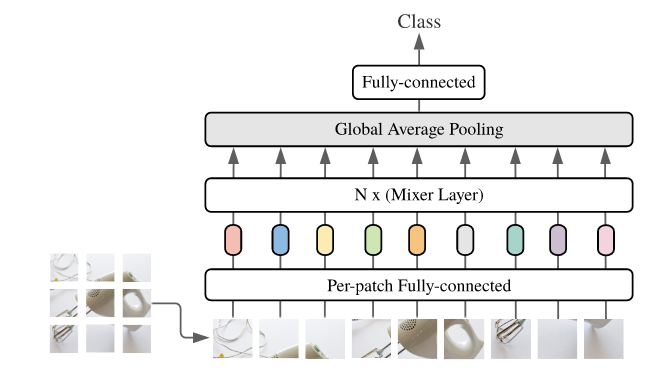

First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

We already code one in the previous notebook on transformer, so here is the solution: 

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape
    x = x.view(B, C, H * W).transpose(1, 2)
    # Shape is now B, N, D
    # With B the batch size
    # With N the number of tokens (N = H * W)
    # With C the embedding dimension

    return x


PatchEmbed()(torch.randn(16, 1, 32, 32)).shape

Now we are going to build a small MLP. Again, we did it with the transformer (see all the similarities?).

But if you feel unconfident about it, please take your time to read and understand the code.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(in_features, hid_features),
        nn.GELU(),
        nn.Linear(hid_features, in_features),
        nn.GELU(),
    )

  def forward(self, x):
    return self.mlp(x)



MLP(5, 20)(torch.randn(3, 16, 5)).shape

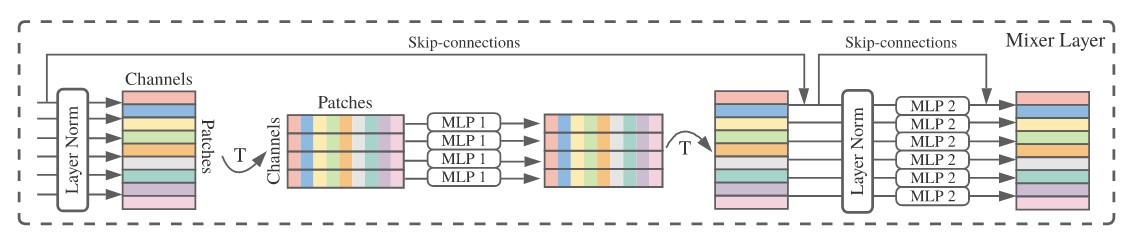

Now, we are going to build a **Mixer Layer**. The main idea of this layer is that our MLPs will transform alternatively the **Channels** and **Patches** axes.

Each transpose **T** operation switch the channels and patches dimensions. Code it, and don't forget the skip connections!

In [ ]:
class Mixer(nn.Module):
  def __init__(self, embed_dim, nb_patches, mlp_ratio=(0.5, 4.0)):
    super().__init__()

    # These represent the hidden dimensions when transforming
    # the tokens and channels dimensions respectively
    tokens_dim = int(mlp_ratio[0] * embed_dim)
    channels_dim = int(mlp_ratio[1] * embed_dim)

    # TODO

  def forward(self, x):
    # TODO
  
    return x


Mixer(6, 4)(torch.randn(2, 4, 6)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/block.py
%pycat block.py

Now we are going to assemble everything together. Note that contrary to transformers, we don't need positional embeddings or class tokens.



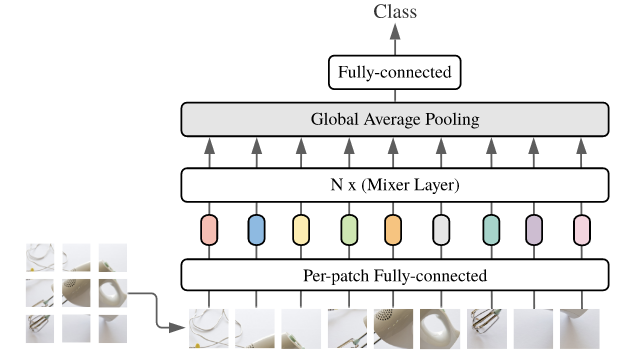

Apply in the following order the **Patch Embeddings**, the multiple **Mixer** layers, and finish with a **layer norm** (not displayed on the image), a **global pooling**, and a **fully connected classifier**.

Along which dimension are you going to pool? Think about that!

In [ ]:
class MLPMixer(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    nb_patches = (28 // patch_size) ** 2
    
    # TODO

  def forward(self, x):
    # TODO
    return x


MLPMixer(6, 3, 7)(torch.randn(16, 1, 32, 32)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/mixer/mixer.py
%pycat mixer.py

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = MLPMixer(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")
  

As for transformers, architectures like MLPMixer really shines on large scale datasets with millions of images.

An important reason is their lack of prior on the domain. Convolutions have a big prior for images by assuming that the visual world is made of local patches that can be recombined together.

Now that you have built a **MLPMixer** (a ultra-recent architecture from 2021!), are you up to the challenge to build its cousin? **ResMLP**!

Have a look at the paper [here](https://arxiv.org/abs/2105.03404), and if you're stuck, have a look at the great [Timm library](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/mlp_mixer.py).